In [57]:
import math
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import axes
import scipy.optimize as opt

# Exercise 8.1

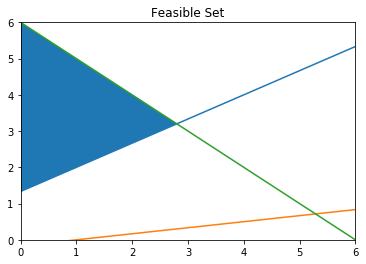

In [44]:
x = np.linspace(0,6,100)
y1 = (2*x+4)/3
y2 = (x-1)/6
y3 = 6-x
plt.plot(x,y1)
plt.plot(x,y2)
plt.plot(x,y3)
plt.fill_between(x,y1,y3,where=y3>=y1,interpolate=True)
plt.axis([0,6,0,6])
plt.title('Feasible Set')
plt.savefig('Feasible_Set')
plt.show()

/Users/rubyzhang/anaconda/lib/python3.6/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


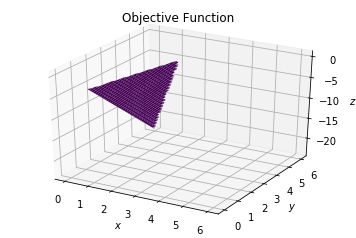

In [56]:
y = np.linspace(0,6,100)
X,Y = np.meshgrid(x,y)
Z = 5*X-4*Y
Z[(2*X+4)/3>Y] = np.nan
Z[(X-1)/6>Y] = np.nan
Z[6-X<Y] = np.nan

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_title('Objective Function')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$z$')
plt.savefig('objective_function_ex1')
plt.show()

In [59]:
c = np.array([-5,4])
A_ub = np.array([[2,-3],[1,-6],[1,1]])
b_ub = np.array([-4,1,6])
results = opt.linprog(c,A_ub=A_ub,b_ub=b_ub)
print(results.x)

[ 2.8  3.2]


As seen from the 3D plot, the optimizer for this problem is the vertex where the green and blue lines intersect, $(2.8, 3.2)$, giving a value of $1.2$. This is verified by the scipy optimizer. 

# Exercise 8.2
## i)

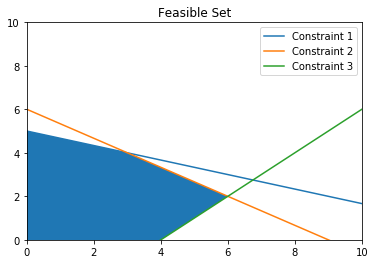

In [90]:
x = np.linspace(0,10,100)
y1 = (1/3)*(15-x)
y2 = (1/3)*(18-2*x)
y3 = x-4
y4 = np.minimum(y1,y2)
plt.plot(x,y1,label='Constraint 1')
plt.plot(x,y2,label='Constraint 2')
plt.plot(x,y3,label='Constraint 3')
plt.legend(loc='best')
plt.fill_between(x,y3,y4,where=y2>=y3,interpolate=True)
plt.axis([0,10,0,10])
plt.title('Feasible Set')
plt.savefig('Feasible_Set_2i')
plt.show()

As seen, there are four vertices that need to be checked. After checking all four vertices manually, we find that the optimal point is $(6,2)$, which gives an optimum value of $20$. 

## ii)

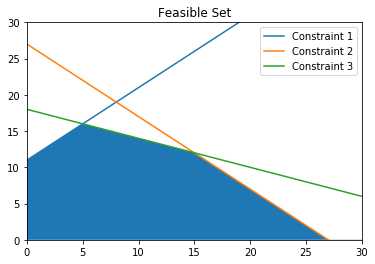

In [118]:
x = np.linspace(0,30,100)
y1 = 11+x
y2 = 27-x
y3 = (1/5)*(90-2*x)
y4 = np.minimum(np.minimum(y1,y2),y3)
plt.plot(x,y1,label='Constraint 1')
plt.plot(x,y2,label='Constraint 2')
plt.plot(x,y3,label='Constraint 3')
plt.legend(loc='best')
plt.fill_between(x,y4,interpolate=True)
plt.axis([0,30,0,30])
plt.title('Feasible Set')
plt.savefig('Feasible_Set_2ii')
plt.show()

As seen, there are four vertices that need to be checked. After checking all four vertices manually, we find that the optimal point is $(15,12)$, which gives an optimum value of $132$. 

# Exercise 8.5

In [203]:
class SimplexSolver(object):
    def __init__(self,c,A,b):
        m,n = A.shape
        x = np.zeros(n)
        var = np.empty(n+m)
        var[:n] = x
        var[n:] = b
        # index list for basic and nonbasic
        L = np.empty_like(var)
        L[:m] = np.arange(n,n+m,1)
        L[m:] = np.arange(0,n,1)
        
        self.A = A
        self.c = c
        self.b = b
        self.var = var
        self.L = L
        
    def init_tableau(self):
        A = self.A
        b = self.b
        c = self.c
        m,n = A.shape
        Abar = np.hstack((A,np.eye(m)))
        cbarT = np.hstack((c,np.zeros(m)))
        col1 = np.hstack((np.array([0]),b))
        col2 = np.vstack((-cbarT,Abar))
        col3 = np.hstack((np.array([1]), np.zeros(m)))
        T = np.vstack((col1,col2.T,col3)).T
        self.T = T
    
    def pivot(self):
        T = np.copy(self.T)
        m,n = T.shape
        L = np.copy(self.L)
        # Find pivot column and rows
        col = np.argmin(T[0,1:])+1
        check = np.argmax(T[1:,col])+1
        if T[check,col]<=0:
            raise ValueError('Solution is unbounded')
        no_zeros = np.copy(T[1:,col])
        no_zeros[no_zeros==0]=-1
        ratios = T[1:,0]/no_zeros
        ratios[T[1:,col]<=0] = np.inf
        row = np.argmin(ratios)+1
        ent = np.where(L==(col-1))[0]
        # Swap entering and leaving
        L[ent], L[row-1] = L[row-1], L[ent]
        # Operations on tableau
        pivot = T[row,col]
        T[row,:] = T[row,:]/pivot
        for i in range(m):
            if i!=row:
                k = T[i,col]
                T[i,:] = T[i,:]-k*T[row,:]
        # Update L and T
        return T,L
    
    def solve(self):
        self.init_tableau()
        check = np.argmin(self.T[0,1:])+1
        sol = self.T[0,check]
        num = 0
        # Check if solution found
        while sol < 0: 
            T1, L1 = self.pivot()
            num += 1
            self.T = T1
            self.L = L1
            check = np.argmin(self.T[0,1:])+1
            sol = self.T[0,check]
            # Check if feasible starting point
            m,n = self.A.shape
            L1 = L1.astype(int)
            values = T1[1:,0]
            values = values[(0<=L1[:m])&(L1[:m]<n)]
            if np.any(values<0):
                 raise ValueError("Infeasible problem")
            # Print dictionary after every pivot
            T1 = np.round(T1,2).astype(str)
            optimum = T1[0,0]
            basic = dict(zip(L1[:m],T1[1:,0]))
            nonbasic = dict(zip(L1[m:],np.zeros(n).astype(str)))
            print('Pivot Number', num, ':')
            print(optimum, basic, nonbasic)
        T = self.T
        L = self.L.astype(int)
        T = np.round(T,2).astype(str)
        optimum = T[0,0]
        m,n = self.A.shape
        basic = dict(zip(L[:m],T[1:,0]))
        nonbasic = dict(zip(L[m:],np.zeros(n).astype(str)))
        return (optimum, basic, nonbasic)

## i)

In [204]:
c = np.array([3, 1])
b = np.array([15,18,4])
A = np.array([[1,3], [2, 3], [1, -1]])
solver = SimplexSolver(c,A,b)
sol = solver.solve()

Pivot Number 1 :
12.0 {2: '11.0', 3: '10.0', 0: '4.0'} {4: '0.0', 1: '0.0'}
Pivot Number 2 :
20.0 {2: '3.0', 1: '2.0', 0: '6.0'} {4: '0.0', 3: '0.0'}


This result is the same as exercise 8.2, the first variable (index 0) has value 6 and the second variable (index 1) has value 2, which gives the optimum value of 20.

## ii)

In [205]:
c = np.array([4,6])
b = np.array([11,27,90])
A = np.array([[-1,1], [1,1], [2,5]])
solver = SimplexSolver(c,A,b)
sol = solver.solve()

Pivot Number 1 :
66.0 {1: '11.0', 3: '16.0', 4: '35.0'} {0: '0.0', 2: '0.0'}
Pivot Number 2 :
116.0 {1: '16.0', 3: '6.0', 0: '5.0'} {4: '0.0', 2: '0.0'}
Pivot Number 3 :
132.0 {1: '12.0', 2: '14.0', 0: '15.0'} {4: '0.0', 3: '0.0'}


This result is the same as exercise 8.2, the first variable (index 0) has value 15 and the second variable (index 1) has value 12, which gives the optimum value of 132.

# Exercise 8.7
## i)

In [206]:
c = np.array([1,2])
b = np.array([-8,6,3])
A = np.array([[-4,-2], [-2,3], [1,0]])
solver = SimplexSolver(c,A,b)
sol = solver.solve()

Pivot Number 1 :
4.0 {2: '-4.0', 1: '2.0', 4: '3.0'} {0: '0.0', 3: '0.0'}
Pivot Number 2 :
11.0 {2: '12.0', 1: '4.0', 0: '3.0'} {4: '0.0', 3: '0.0'}


The optimizer is $(3,4)$, which gives the optimum value of $11$.

## ii)

In [210]:
c = np.array([5,2])
b = np.array([15,15,-12])
A = np.array([[5,3], [3,5],[4,-3]])
solver = SimplexSolver(c,A,b)
sol = solver.solve()

ValueError: Infeasible problem

As seen, this problem is infeasible, thus there is no solution.

## iii)

In [211]:
c = np.array([-3,1])
b = np.array([4,6])
A = np.array([[0,1], [-2,3]])
solver = SimplexSolver(c,A,b)
sol = solver.solve()

Pivot Number 1 :
2.0 {2: '2.0', 1: '2.0'} {0: '0.0', 3: '0.0'}


The optimizer is $(0,2)$, which gives the optimum value of $2$.

# Exercise 8.13

Utilizing the Simplex Algorithm, we start at the origin since it is a feasble point in this situation. Then we choose a nonbasic variable (decision variables in the first iteration) with a positive coefficient. If there are none, then $\mathbf{x}=\mathbf{0}$ is the optimizer. Suppose there is a nonbasic variable $x_i$ with a positive coefficient. Then we must select the most binding variable from the basic variables. However, since $\mathbf{b}=\mathbf{0}$, then the slack variable can either be increased indefinitely (if the coefficient on $x_j$ in $\mathbf{A}$ is negative), in which case the problem is unbounded, or cannot be decreased at all from 0. Therefore, either the origin in an optimum or the problem is unbounded.

# Exercise 8.15
In order to prove the weak duality theorem, we must show that if $\mathbf{y}\in\mathbb{R}^m$ is feasible for the dual and $\mathbf{x}\in\mathbb{R}^n$ is feasible for the primal, then, $\mathbf{c}^T\mathbf{x}\leq\mathbf{b}^T\mathbf{y}$. From the dual problem we have that $\mathbf{x}^T\mathbf{A}^T\mathbf{y} \geq \mathbf{x}^T\mathbf{c}$ and from the primal problem we have that $(\mathbf{A}\mathbf{x})^T \leq \mathbf{b}^T \Longrightarrow \mathbf{x}^T\mathbf{A}^T\mathbf{y} \leq \mathbf{b}^T\mathbf{y}$. Since $\mathbf{x}^T\mathbf{c} = \mathbf{c}^T\mathbf{x}$, then we have that $\mathbf{c}^T\mathbf{x}\leq\mathbf{b}^T\mathbf{y}$.

# Exercise 8.17

Suppose we have the following dual problem:
    \begin{align*}
        \text{minimize } & \mathbf{b}^T\mathbf{y} \\
        \text{subject to } & A^T\mathbf{y} \geq \mathbf{c} , \\
        & \mathbf{y} \geq \mathbf{0}
    \end{align*}
Then we can rewrite the dual problem in standard form:
    \begin{align*}
        \text{maximize } & -\mathbf{b}^T\mathbf{y} \\
        \text{subject to } & -A^T\mathbf{y} \leq -\mathbf{c} , \\
        & \mathbf{y} \geq \mathbf{0}
    \end{align*}
The dual of the dual problem in standard form is then: 
    \begin{align*}
        \text{minimize } & -\mathbf{c}^T\mathbf{x} \\
        \text{subject to } & -A\mathbf{x} \geq -\mathbf{b} , \\
        & \mathbf{x} \geq \mathbf{0}
    \end{align*}
which can be rewritten as the primal problem:
    \begin{align*}
        \text{maximize } & \mathbf{c}^T\mathbf{x} \\
        \text{subject to } & A\mathbf{x} \leq \mathbf{b} , \\
        & \mathbf{x} \geq \mathbf{0}
    \end{align*}
Therefore, the dual of the dual problem is the primal problem.

# Exercise 8.18

The dual of the primal problem is:
    \begin{align*}
        \text{minimize } & 3y_1+5y_2+4y_3 \\
        \text{subject to } & 2y_1+y_2+2y_3 \geq 1 \\
        & y_1+3y_2+3y_3 \geq 1 \\
        & y_1,y_2,y_3 \geq 0
    \end{align*}
We can put it in standard form and use the simplex solver:
    \begin{align*}
        \text{maximize } & -3y_1-5y_2-4y_3 \\
        \text{subject to } & -2y_1-y_2-2y_3 \leq -1 \\
        & -y_1-3y_2-3y_3 \leq -1 \\
        & y_1,y_2,y_3 \geq 0
    \end{align*}

In [225]:
# Solve for primal problem
c = np.array([1,1])
b = np.array([3,5,4])
A = np.array([[2,1], [1,3],[2,3]])
results = opt.linprog(-c,A_ub=A,b_ub=b)
print(results)

     fun: -1.75
 message: 'Optimization terminated successfully.'
     nit: 2
   slack: array([ 0.  ,  2.25,  0.  ])
  status: 0
 success: True
       x: array([ 1.25,  0.5 ])


In [226]:
# Solve for dual problem
c = np.array([-3,-5,-4])
b = np.array([-1,-1])
A = np.array([[-2,-1,-2],[-1,-3,-3]])
results = opt.linprog(-c,A_ub=A,b_ub=b)
print(results)

     fun: 1.75
 message: 'Optimization terminated successfully.'
     nit: 2
   slack: array([ 0.,  0.])
  status: 0
 success: True
       x: array([ 0.25,  0.  ,  0.25])


Note that if we plug in optimal solution $(1.25,0.5)$ to the primal problem, we get $1.75$, which is the same optimal value as plugging in the solution $(0.25,0,0.25)$ into the objective function of the dual problem.